In [ ]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import random
import csv
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
#1# read from the excel dataset from google drive
#mount gdrive directory
from google.colab import drive
drive.mount('/content/drive')

#load data from excel dataset
fileNameFullPath='/content/drive/MyDrive/mai25067-assignment2/Dataset2Use_Assignment2.xlsx'
dataframe = pd.read_excel(fileNameFullPath)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#3# check for NaN values and alert the user
#check for Nan values
nan_report = dataframe.isna().sum()

# Concatenate the reports side by side and display the report
report = pd.concat([nan_report], axis=1, keys=['NaN Count'])
print("===================================")
print("Missing Values (NaN) Report")
print("===================================")
print(report)
print("===================================")

# Provide a relative message to the user
if report.values.max() == 0:
    print("\nGood news! There are no missing values in the DataFrame.")
else:
    print("\nPlease be aware that there are missing values in the DataFrame. Consider handling them appropriately.")

Missing Values (NaN) Report
                                                NaN Count
365* ( Β.Υ / Κοστ.Πωλ )                                 0
Λειτ.Αποτ/Συν.Ενεργ. (ROA)                              0
ΧΡΗΜ.ΔΑΠΑΝΕΣ / ΠΩΛΗΣΕΙΣ                                 0
 ΠΡΑΓΜΑΤΙΚΗ ΡΕΥΣΤΟΤΗΤΑ :  (ΚΕ-ΑΠΟΘΕΜΑΤΑ) / Β.Υ          0
(ΑΠΑΙΤ.*365) / ΠΩΛ.                                     0
Συν.Υποχρ/Συν.Ενεργ                                     0
Διάρκεια Παραμονής Αποθεμάτων                           0
Λογαριθμος Προσωπικού                                   0
ΕΝΔΕΙΞΗ ΕΞΑΓΩΓΩΝ                                        0
ΕΝΔΕΙΞΗ ΕΙΣΑΓΩΓΩΝ                                       0
ΕΝΔΕΙΞΗ ΑΝΤΙΠΡΟΣΩΠΕΙΩΝ                                  0
ΕΝΔΕΙΞΗ ΑΣΥΝΕΠΕΙΑΣ (=2) (ν+1)                           0
ΕΤΟΣ                                                    0

Good news! There are no missing values in the DataFrame.


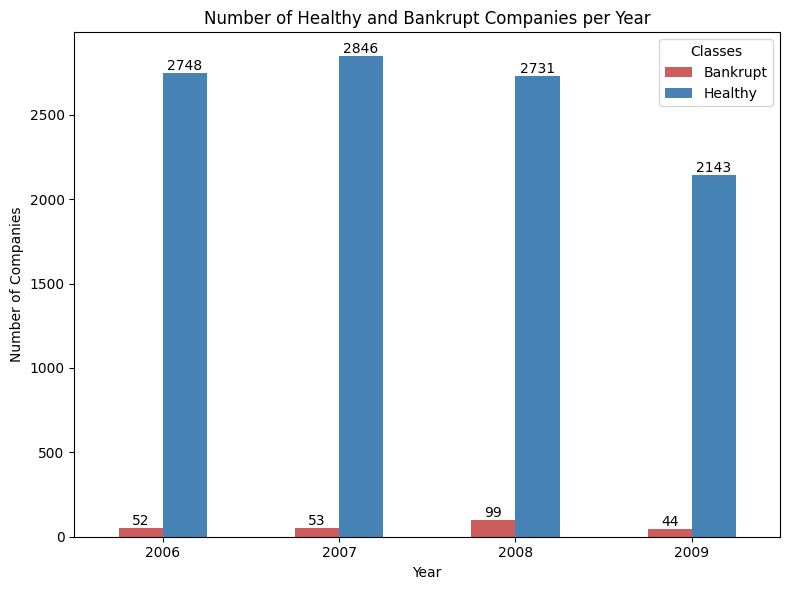

In [ ]:
#2a# print plots showing the healthy (H) and bankrupt (B) companies per year

# Specify the Drive Path
drivePath = '/content/drive/MyDrive/mai25067-assignment2'

# Check if the folder exists, and create it if necessary
if not os.path.exists(drivePath):
    os.makedirs(drivePath)

# Check if the folder exists, and create it if necessary
figuresFolderPath = os.path.join(drivePath, 'Figures')
if not os.path.exists(figuresFolderPath):
    os.makedirs(figuresFolderPath)

# store the column titles
columnTitles = dataframe.columns

#the column that shows the company's state is L hence 11, and the year is M hence 12
classColumn = columnTitles[11]
yearColumn = columnTitles[12]

#define classes : Healthy (H), Bankrupt (B), using map to show text instead of numbers
classLabels = {1: 'Healthy', 2: 'Bankrupt'}

#count the number of each class using the map created
classCount = dataframe[classColumn].map(classLabels.get)

# count occurences of 'H' and 'B' per year
classCountsPerYear = dataframe.groupby([yearColumn, classCount]).size().unstack(fill_value=0)

#create the plot
plot2a = classCountsPerYear.plot(kind='bar', figsize=(8,6), color=['indianred', 'steelblue'])

#add he count number for each bar
for c in  plot2a.containers:
  plot2a.bar_label(c, label_type='edge')

#configure the plot info and show it
plt.xlabel('Year')
plt.ylabel('Number of Companies')
plt.title('Number of Healthy and Bankrupt Companies per Year')
plt.xticks(rotation=0) #x axis labels horizontal
plt.legend(title='Classes')
plt.tight_layout()
plt.savefig(os.path.join(figuresFolderPath, 'HealthyAndBankruptPerYear.png'))
plt.show()
print()

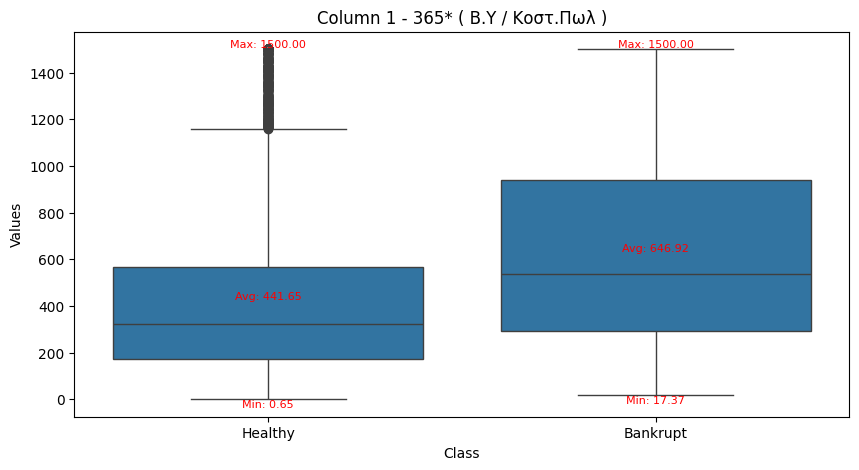

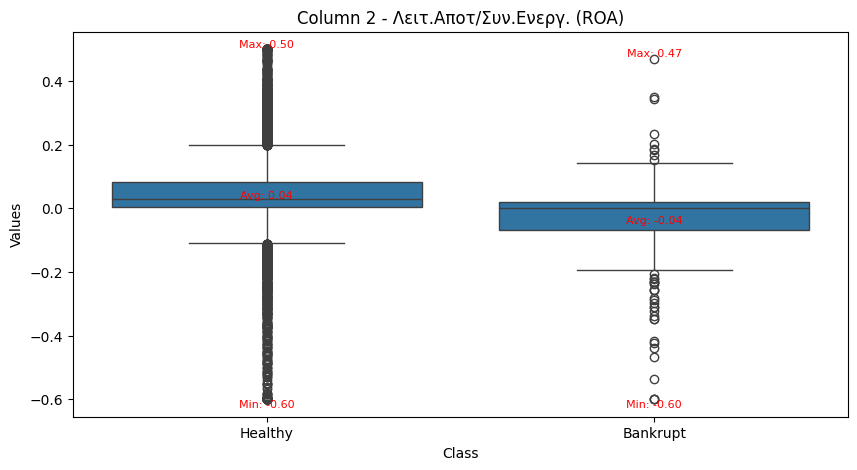

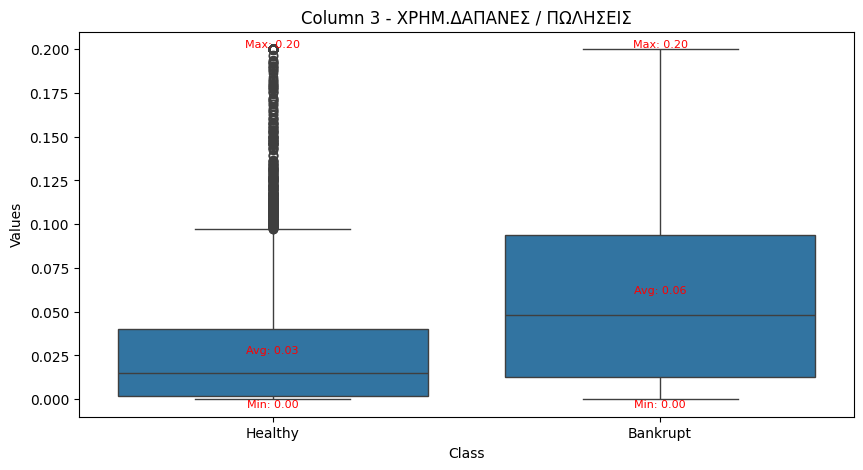

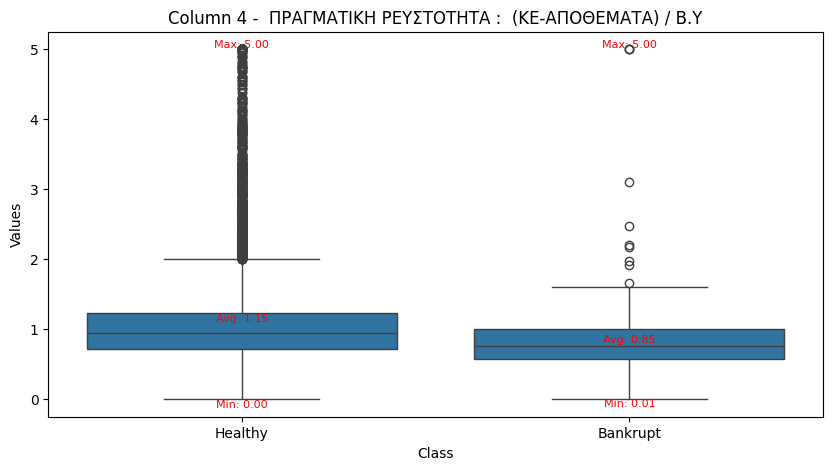

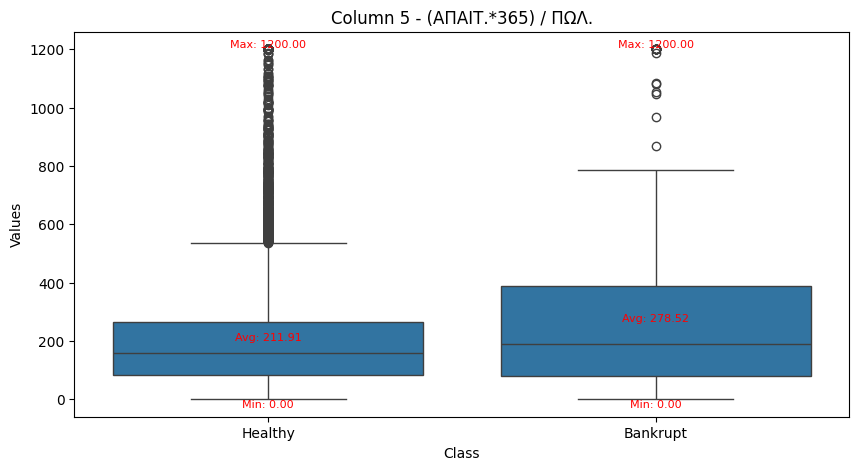

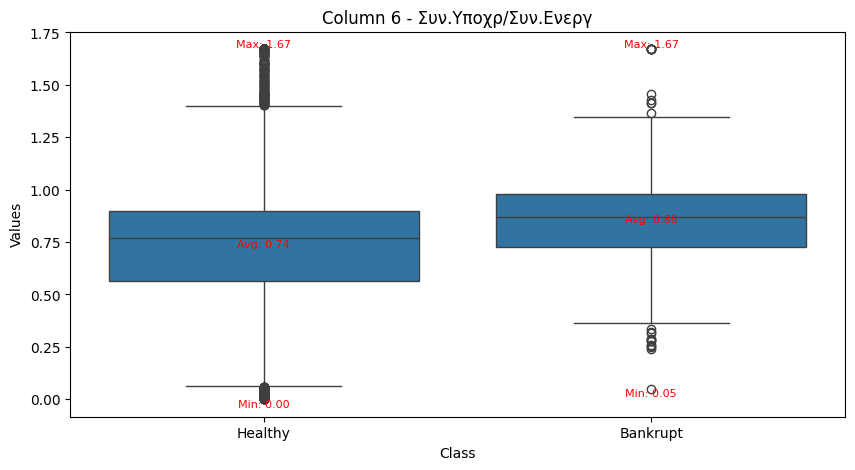

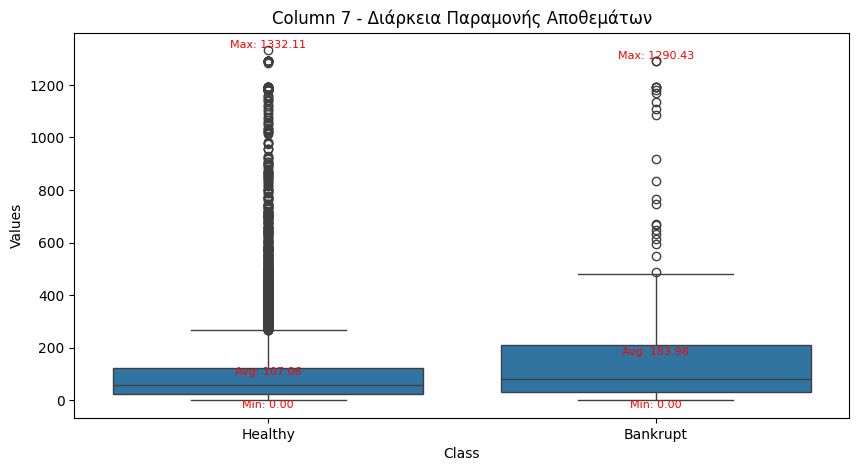

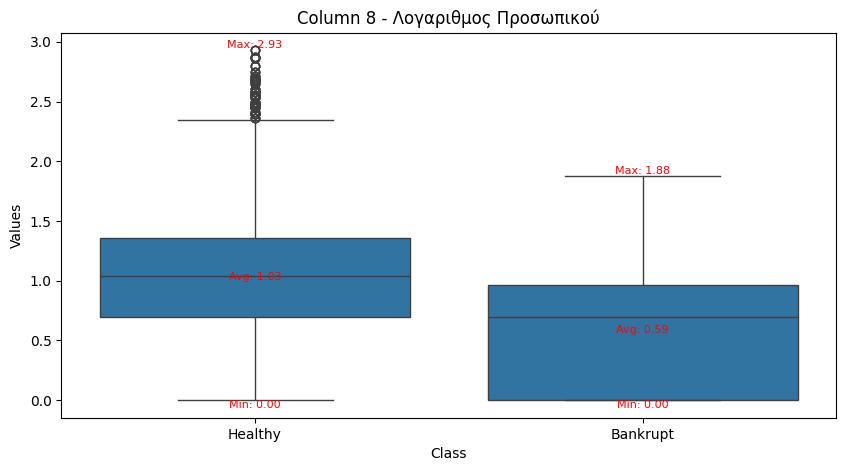

In [ ]:
#2b# print a boxplot showing min, max, avg for every indicator per company state (H/B)
# iterate through each column and create a separate box plot for each class
for col_idx in range(0, 8):
    plt.figure(figsize=(10, 5))  # Adjust the figsize as needed

    # Create a box plot using seaborn, grouping by the 'Class' column
    plot = sns.boxplot(x=classColumn, y=dataframe.columns[col_idx], data=dataframe)

    plt.title(f"Column {col_idx + 1} - {columnTitles[col_idx]}")
    plt.xlabel('Class')
    plt.ylabel('Values')

    # Replace numeric ticks with corresponding labels
    plt.xticks(ticks=[0, 1], labels=['Healthy', 'Bankrupt'])

    # Add min, max, avg to the plot
    for i, class_label in enumerate([1, 2]):
        subset = dataframe[dataframe[classColumn] == class_label][dataframe.columns[col_idx]]
        if not subset.empty:
            min = subset.min()
            max = subset.max()
            avg = subset.mean()

            # Set annotation position slightly above/below the box
            x = i
            y_pos = subset.median()

            plot.text(x, min, f"Min: {min:.2f}", ha='center', va='top', fontsize=8, color='red')
            plot.text(x, max, f"Max: {max:.2f}", ha='center', va='bottom', fontsize=8, color='red')
            plot.text(x, avg, f"Avg: {avg:.2f}", ha='center', va='center', fontsize=8, color='red')

    plt.savefig(os.path.join(figuresFolderPath, f'boxplot_{col_idx}.png'))
    plt.show()
    print()

In [ ]:
#4# normalize the data
#create input data to normalize. data derived from columns A:H
inputData = dataframe.iloc[:, 0:8].values

#output data
outputData = dataframe.iloc[:, 11].values

#show the min, max values for each column
np.set_printoptions(precision=4, suppress=True)  # Set precision and disable scientific notation
print("==============================================")
print("Min/Max Values BEFORE Normalization")
print("==============================================")
print("Max values per feature: ", np.max(inputData, axis=0))
print("Min values per feature: ", np.min(inputData, axis=0))
print()

#data normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
inputData = scaler.fit_transform(inputData)
print("============================================")
print("Min/Max Values AFTER Normalization")
print("============================================")
print("Max values per feature: ", np.max(inputData, axis=0))
print("Min values per feature: ", np.min(inputData, axis=0))

Min/Max Values BEFORE Normalization
Max values per feature:  [1500.        0.5       0.2       5.     1200.        1.67   1332.1055
    2.9299]
Min values per feature:  [ 0.6544 -0.6     0.      0.0007  0.      0.0004  0.      0.    ]

Min/Max Values AFTER Normalization
Max values per feature:  [1. 1. 1. 1. 1. 1. 1. 1.]
Min values per feature:  [0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
#5# Use Stratifield kfold to create 4 folds
n_splits = 4
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

#create dataframe to store results
#columns = ["Classifier Name", "Fold", "Set", "Balanced/Unbalanced", "Number of training samples", "Number of Bankrupt companies in training sample", "TP", "TN", "FP", "FN", "AUC-ROC", "Acc", "Pre", "Rec", "F1"]
columns = ["Classifier Name", "Fold", "Set", "Balanced/Unbalanced", "Number of training samples", "Number of Bankrupt companies in training sample", "TP", "TN", "FP", "FN", "AUC-ROC"]

# Create an empty DataFrame with the specified columns
resultsDataframe = pd.DataFrame(columns=columns)


In [ ]:
#function to balance the fold
def balanceFold(x_train, y_train):

  #the whole dataframe for the current fold
  dataframe_train = pd.DataFrame(x_train)
  dataframe_train['class'] = y_train

  #seperate classes in different dataframes
  dataframe_healthy = dataframe_train[dataframe_train['class'] == 1]
  dataframe_bankrupt = dataframe_train[dataframe_train['class'] == 2]

  #resample ONLY the healthy dataframe using rule: 3 healthy to 1 bankrupt
  dataframe_healthy_resampled = resample(dataframe_healthy, replace=False, n_samples=3 * len(dataframe_bankrupt), random_state=42)

  #combine the resampled healthy with the bankrupted to a single dataframe
  dataframe_train_resampled = pd.concat([dataframe_healthy_resampled, dataframe_bankrupt])
  dataframe_train_resampled = dataframe_train_resampled.sample(frac=1, random_state=42)

  x_train = dataframe_train_resampled.drop(columns='class').to_numpy()
  y_train = dataframe_train_resampled['class'].to_numpy()
  resampled_indexes = dataframe_train_resampled.index

  return x_train, y_train, resampled_indexes

In [ ]:
#9# for each model print confusion matrices for train & test sets, calculate certain metrics
#print the results with 2 decimal precision and store results in a dataframe
#function to train the model
def one_model_sim_function(modelName, clf, inputData, outputData,\
                           train_index, test_index,\
                           figuresFolderPath, balancingRatio, foldNum):
  print("==============================================")
  global resultsDataframe
  print('Working with classifier ', modelName)

  #train the classifier
  start_time = time.time() # Record start time
  clf.fit(inputData[train_index,:], outputData[train_index])
  end_time = time.time() # Record end time

  trainingTime = end_time - start_time
  print('Finished with training in {:.4f} seconds'.format(trainingTime))

  #use the trained classifier to estimate the outputs
  start_time = time.time() # Record start time
  predicted_output_values_train =\
    clf.predict(inputData[train_index,:])
  end_time = time.time() # Record end time

  predTimeTrain = end_time - start_time

  start_time = time.time() # Record start time
  predicted_output_values_test =\
    clf.predict(inputData[test_index,:])
  end_time = time.time() # Record end time

  predTimeTest = end_time - start_time

  #calculate scores of train set / positive label should be 2, NOT the default 1
  acc_train = accuracy_score(outputData[train_index], predicted_output_values_train)
  pre_train = precision_score(outputData[train_index], predicted_output_values_train, pos_label=2)
  rec_train = recall_score(outputData[train_index], predicted_output_values_train, pos_label=2)
  f1_train = f1_score(outputData[train_index], predicted_output_values_train, pos_label=2)
  try:
    auc_train = roc_auc_score(outputData[train_index], clf.predict_proba(inputData[train_index,:])[:,1])
  except AttributeError:
    auc_train = roc_auc_score(outputData[train_index], clf.decision_function(inputData[train_index,:]))

  #calculate scores of test set / positive label should be 2, NOT the default 1
  acc_test = accuracy_score(outputData[test_index], predicted_output_values_test)
  pre_test = precision_score(outputData[test_index], predicted_output_values_test, pos_label=2)
  rec_test = recall_score(outputData[test_index], predicted_output_values_test, pos_label=2)
  f1_test = f1_score(outputData[test_index], predicted_output_values_test, pos_label=2)
  try:
    auc_test = roc_auc_score(outputData[test_index], clf.predict_proba(inputData[test_index,:])[:,1])
  except AttributeError:
      auc_test = roc_auc_score(outputData[test_index], clf.decision_function(inputData[test_index,:]))

  #print scores
  print("Train set")
  print(f"Acc: {acc_train:.2f}, Pre: {pre_train:.2f}, Rec: {rec_train:.2f}, F1: {f1_train:.2f}, AUC: {auc_train:.2f}")
  print("Test set")
  print(f"Acc: {acc_test:.2f}, Pre: {pre_test:.2f}, Rec: {rec_test:.2f}, F1: {f1_test:.2f}, AUC: {auc_test:.2f}")

  #confusion matrices here
  cf_matrix_train = confusion_matrix(outputData[train_index],\
                                  predicted_output_values_train )

  cf_matrix_test = confusion_matrix(outputData[test_index],\
                                predicted_output_values_test )

  #store values for info dataframe
  tn_train, fp_train, fn_train, tp_train = cf_matrix_train.ravel()
  tn_test, fp_test, fn_test, tp_test = cf_matrix_test.ravel()
  num_train_samples = len(train_index)
  num_bankrupt_train = sum(outputData[train_index] == 2)

  #create some figures with confusion matrices
  funcy_cf_plot(cf_matrix_train, ['Healthy','Bankrupt'],\
                modelName + str(foldNum) + balancingRatio + "Train",\
                figuresFolderPath)
  funcy_cf_plot(cf_matrix_test, ['Healthy','Bankrupt'],\
                modelName + str(foldNum) + "unbalanced" + "Test",\
                figuresFolderPath)

  print('Finished with saving the confusion matrices. ')

  #add lines with results to dataframe
  new_data_train = pd.DataFrame([{"Classifier Name": modelName,"Fold": foldNum, "Set": "Train", "Balanced/Unbalanced": balancingRatio, "Number of training samples": num_train_samples,\
                                  "Number of Bankrupt companies in training sample": num_bankrupt_train, "TP": tp_train, "TN":tn_train, "FP":fp_train, "FN":fn_train, "AUC-ROC": round(auc_train,2)}])
                                  #,"Acc": round(acc_train,2), "Pre": round(pre_train, 2), "Rec" : round(rec_train, 2), "F1": round(f1_train,2)}])
  resultsDataframe = pd.concat([resultsDataframe, new_data_train], ignore_index=True)
  new_data_test = pd.DataFrame([{"Classifier Name": modelName, "Fold": foldNum, "Set": "Test", "Balanced/Unbalanced": "unbalanced", "Number of training samples": num_train_samples,\
                                 "Number of Bankrupt companies in training sample": num_bankrupt_train, "TP": tp_test, "TN":tn_test, "FP":fp_test, "FN":fn_test, "AUC-ROC": round(auc_test,2)}])
                                 #,"Acc": round(acc_test,2), "Pre": round(pre_test, 2), "Rec" : round(rec_test, 2), "F1": round(f1_test,2)}])
  resultsDataframe = pd.concat([resultsDataframe, new_data_test], ignore_index=True)

In [ ]:
#function make the confusion matrices
#build a funcy confusion matrix
import seaborn as sns #funcier plots for confusion matrix
def funcy_cf_plot(cf_matrix, class_names, fullMatrixName, directoryToSave):
  #class names: list of the form ['a','b','b',etc]
  #keep two decimals
  group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

  labels = [f"{v1}\n{v2}\n" for v1, v2 in
            zip(group_counts,group_percentages)]

  labels = np.asarray(labels).reshape(2,2)

  ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

  #ax.set_title('Seaborn Confusion Matrix with labels\n\n');
  ax.set_xlabel('Predicted company status')
  ax.set_ylabel('Actual company status ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(class_names)
  ax.yaxis.set_ticklabels(class_names)

  #save the figure to dedicated directory to use in the report
  figure_path = os.path.join(directoryToSave, fullMatrixName)
  plt.savefig(figure_path)

  # Display the visualization of the Confusion Matrix.
  plt.show()
  print()

We are currently in Fold set: 1
-----------------
Initial Training Set
-----------------
Healthy companies : 7851
Bankrupt companies : 186
Total companies in training set: 8037
-----------------------------------

Resampling Training Set to fit 3:1 ratio
-----------------
Resampled Training Set
-----------------
Healthy companies : 558
Bankrupt companies : 186
Total companies in resampled training set: 744
-----------------------------------
-----------------
Test Set
-----------------
Healthy companies : 2617
Bankrupt companies : 62
Total companies in test set: 2679

Working with classifier  LDA
Finished with training in 0.0017 seconds
Train set
Acc: 0.82, Pre: 0.74, Rec: 0.43, F1: 0.54, AUC: 0.84
Test set
Acc: 0.91, Pre: 0.12, Rec: 0.45, F1: 0.19, AUC: 0.83


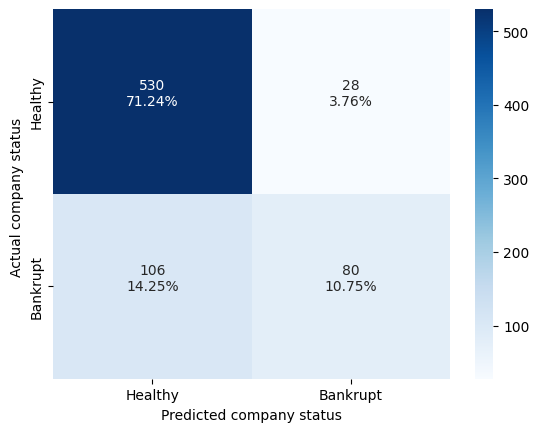

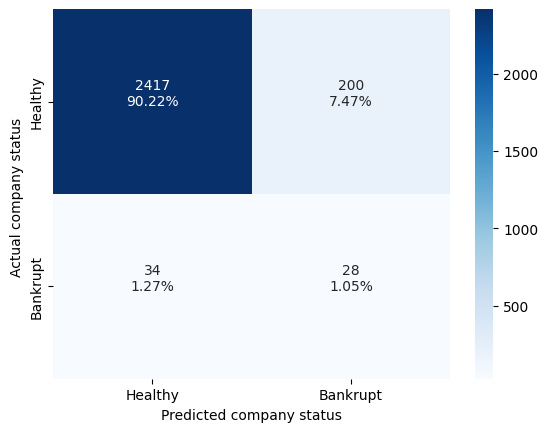


Finished with saving the confusion matrices. 
Working with classifier  LR
Finished with training in 0.0156 seconds
Train set
Acc: 0.81, Pre: 0.74, Rec: 0.38, F1: 0.50, AUC: 0.84
Test set
Acc: 0.93, Pre: 0.13, Rec: 0.35, F1: 0.19, AUC: 0.83


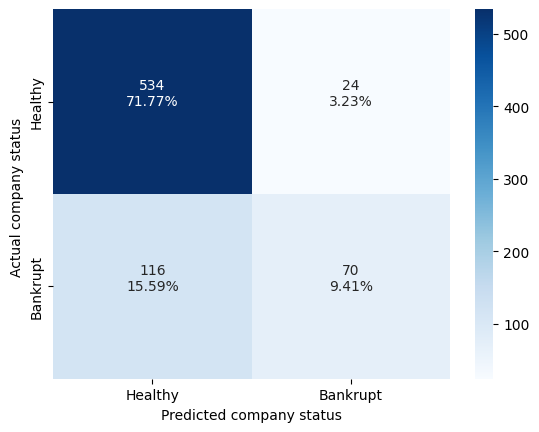

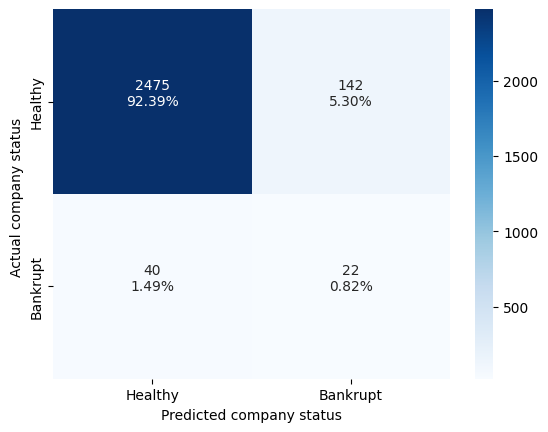


Finished with saving the confusion matrices. 
Working with classifier  Ctree
Finished with training in 0.0086 seconds
Train set
Acc: 1.00, Pre: 1.00, Rec: 1.00, F1: 1.00, AUC: 1.00
Test set
Acc: 0.81, Pre: 0.06, Rec: 0.53, F1: 0.11, AUC: 0.67


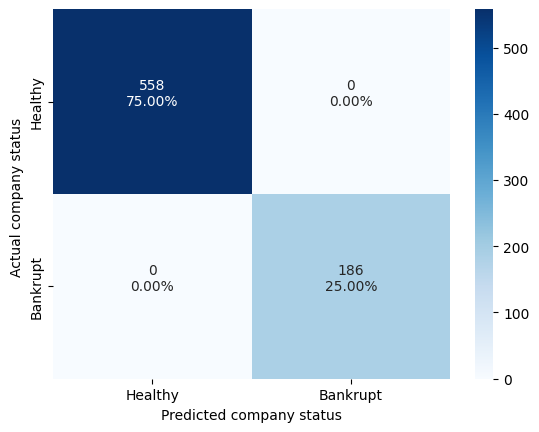

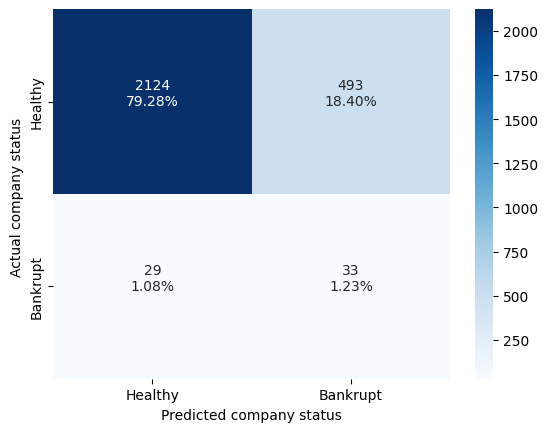


Finished with saving the confusion matrices. 
Working with classifier  RF
Finished with training in 0.2362 seconds
Train set
Acc: 1.00, Pre: 1.00, Rec: 1.00, F1: 1.00, AUC: 1.00
Test set
Acc: 0.91, Pre: 0.14, Rec: 0.52, F1: 0.22, AUC: 0.82


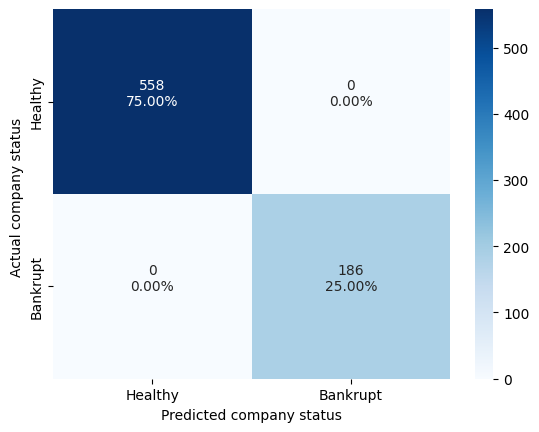

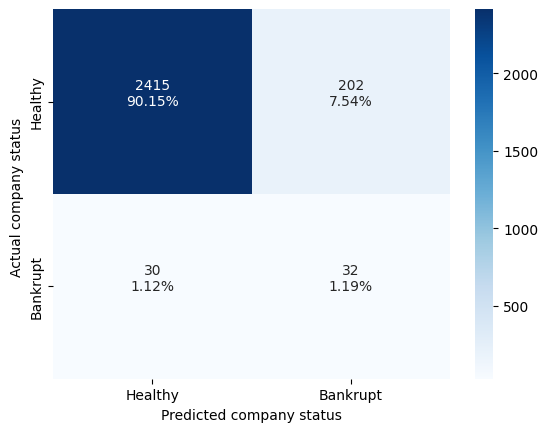


Finished with saving the confusion matrices. 
Working with classifier  kNN
Finished with training in 0.0031 seconds
Train set
Acc: 0.85, Pre: 0.75, Rec: 0.60, F1: 0.67, AUC: 0.91
Test set
Acc: 0.88, Pre: 0.09, Rec: 0.48, F1: 0.16, AUC: 0.77


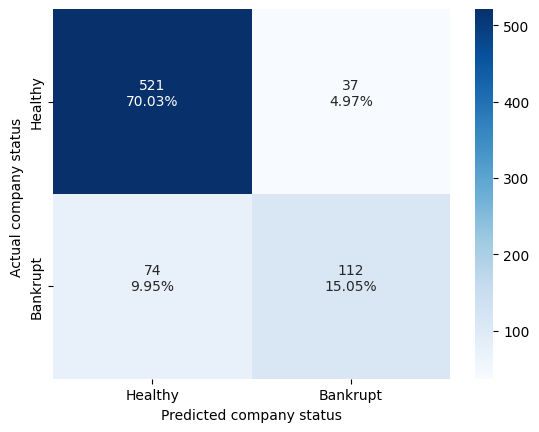

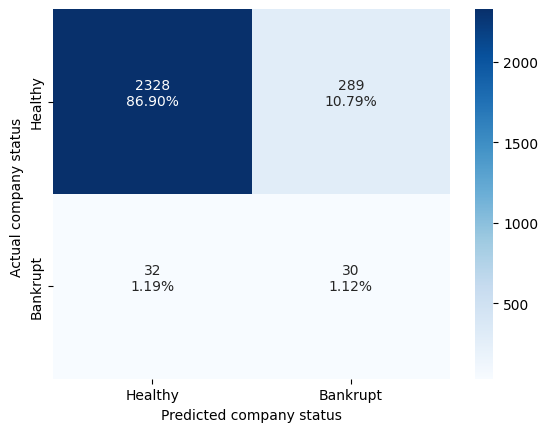


Finished with saving the confusion matrices. 
Working with classifier  NB
Finished with training in 0.0028 seconds
Train set
Acc: 0.79, Pre: 0.62, Rec: 0.43, F1: 0.51, AUC: 0.82
Test set
Acc: 0.88, Pre: 0.08, Rec: 0.37, F1: 0.13, AUC: 0.80


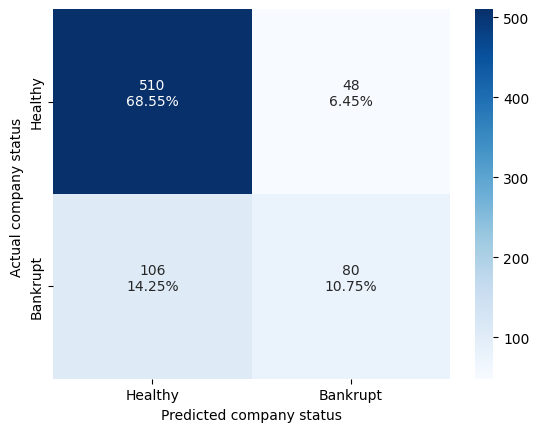

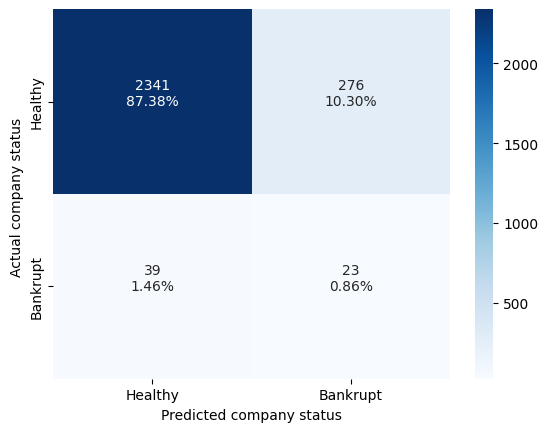


Finished with saving the confusion matrices. 
Working with classifier  SVM
Finished with training in 0.0144 seconds
Train set
Acc: 0.85, Pre: 0.81, Rec: 0.49, F1: 0.62, AUC: 0.88
Test set
Acc: 0.91, Pre: 0.12, Rec: 0.42, F1: 0.19, AUC: 0.82


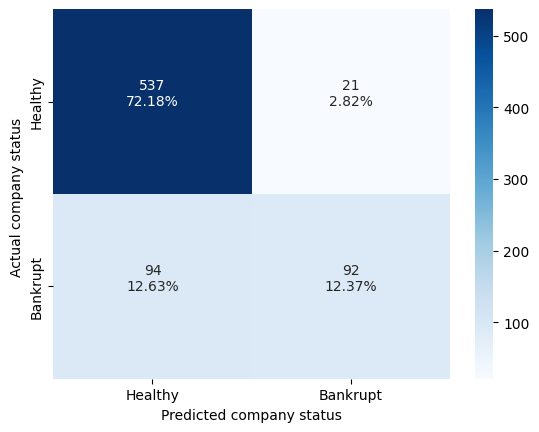

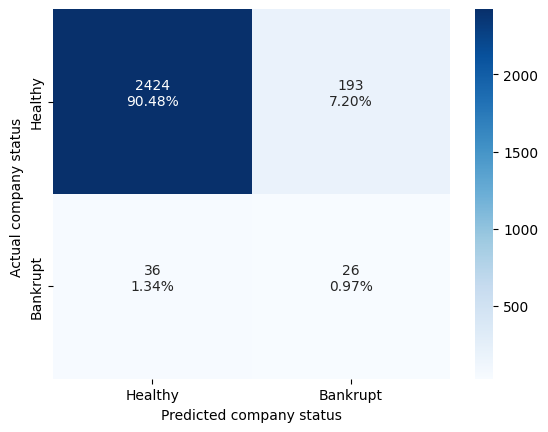


Finished with saving the confusion matrices. 
Working with classifier  GB
Finished with training in 0.2515 seconds
Train set
Acc: 0.94, Pre: 0.96, Rec: 0.82, F1: 0.88, AUC: 0.99
Test set
Acc: 0.89, Pre: 0.11, Rec: 0.52, F1: 0.18, AUC: 0.81


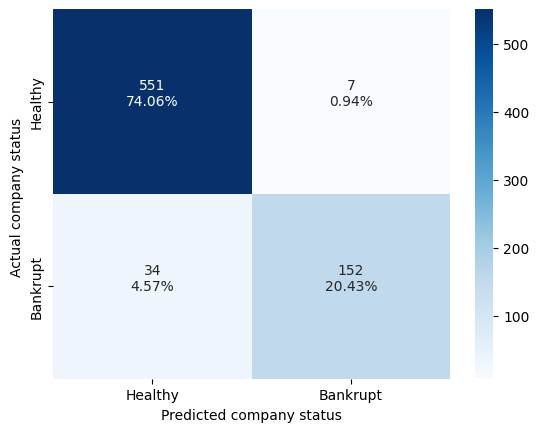

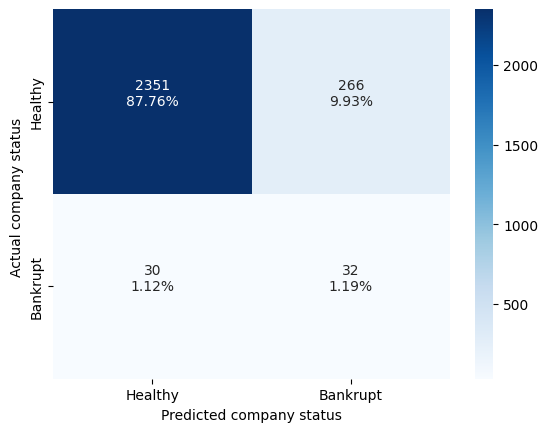


Finished with saving the confusion matrices. 
We are currently in Fold set: 2
-----------------
Initial Training Set
-----------------
Healthy companies : 7851
Bankrupt companies : 186
Total companies in training set: 8037
-----------------------------------

Resampling Training Set to fit 3:1 ratio
-----------------
Resampled Training Set
-----------------
Healthy companies : 558
Bankrupt companies : 186
Total companies in resampled training set: 744
-----------------------------------
-----------------
Test Set
-----------------
Healthy companies : 2617
Bankrupt companies : 62
Total companies in test set: 2679

Working with classifier  LDA
Finished with training in 0.0022 seconds
Train set
Acc: 0.79, Pre: 0.65, Rec: 0.34, F1: 0.45, AUC: 0.81
Test set
Acc: 0.92, Pre: 0.15, Rec: 0.50, F1: 0.23, AUC: 0.87


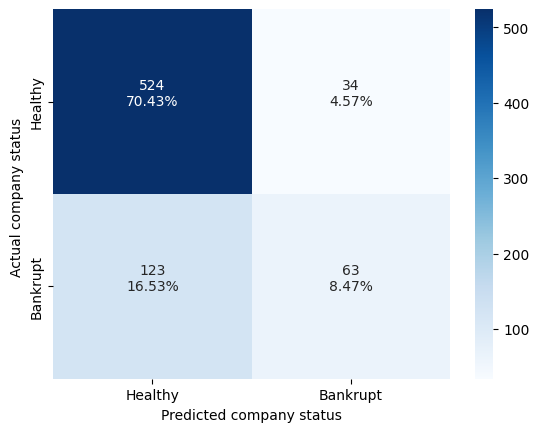

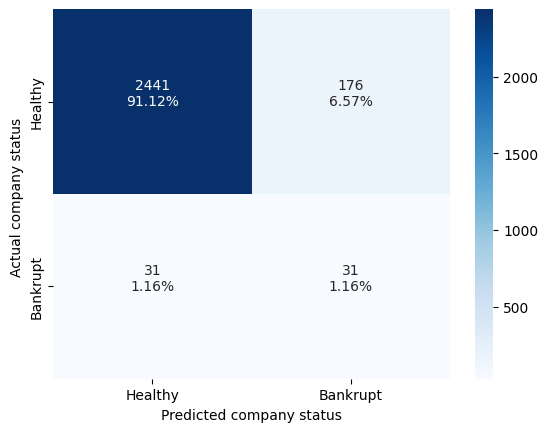


Finished with saving the confusion matrices. 
Working with classifier  LR
Finished with training in 0.0386 seconds
Train set
Acc: 0.78, Pre: 0.68, Rec: 0.25, F1: 0.37, AUC: 0.81
Test set
Acc: 0.94, Pre: 0.15, Rec: 0.35, F1: 0.21, AUC: 0.87


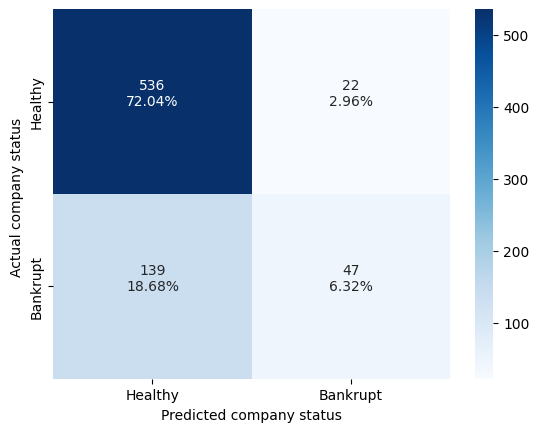

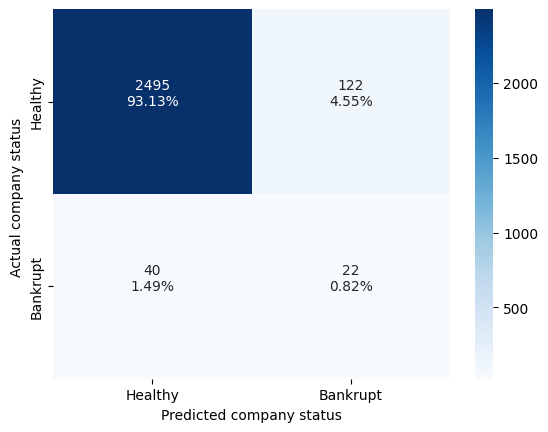


Finished with saving the confusion matrices. 
Working with classifier  Ctree
Finished with training in 0.0088 seconds
Train set
Acc: 1.00, Pre: 1.00, Rec: 1.00, F1: 1.00, AUC: 1.00
Test set
Acc: 0.80, Pre: 0.05, Rec: 0.48, F1: 0.10, AUC: 0.64


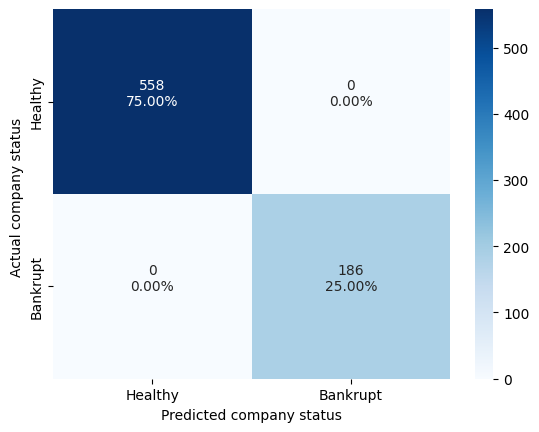

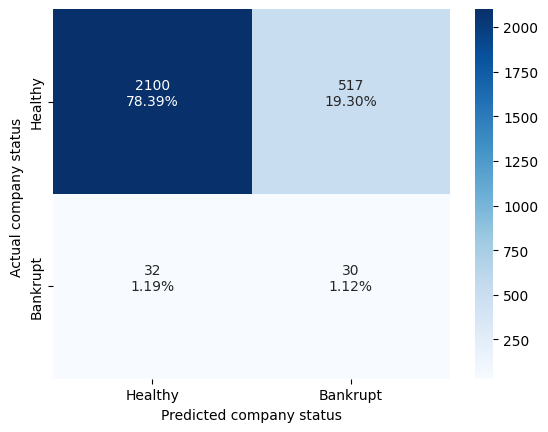


Finished with saving the confusion matrices. 
Working with classifier  RF
Finished with training in 0.2895 seconds
Train set
Acc: 1.00, Pre: 1.00, Rec: 1.00, F1: 1.00, AUC: 1.00
Test set
Acc: 0.93, Pre: 0.16, Rec: 0.48, F1: 0.25, AUC: 0.86


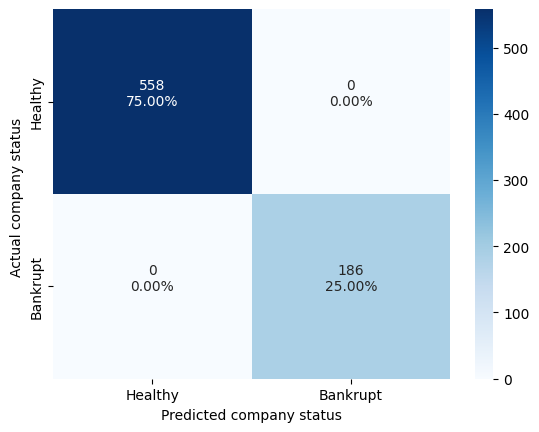

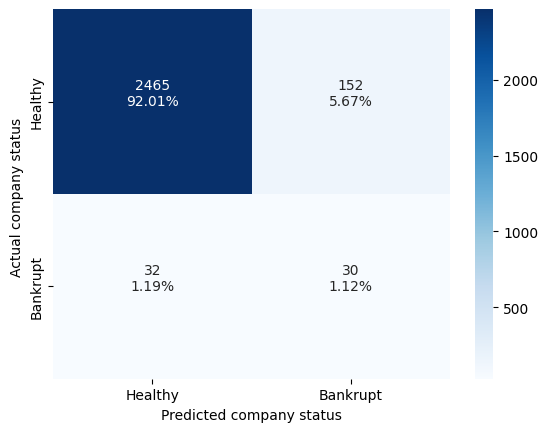


Finished with saving the confusion matrices. 
Working with classifier  kNN
Finished with training in 0.0031 seconds
Train set
Acc: 0.82, Pre: 0.70, Rec: 0.48, F1: 0.57, AUC: 0.88
Test set
Acc: 0.89, Pre: 0.11, Rec: 0.56, F1: 0.19, AUC: 0.81


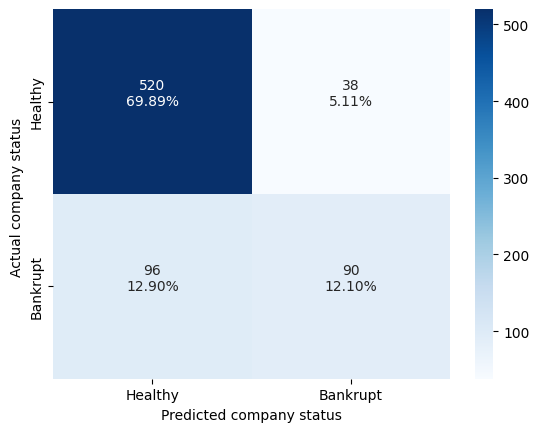

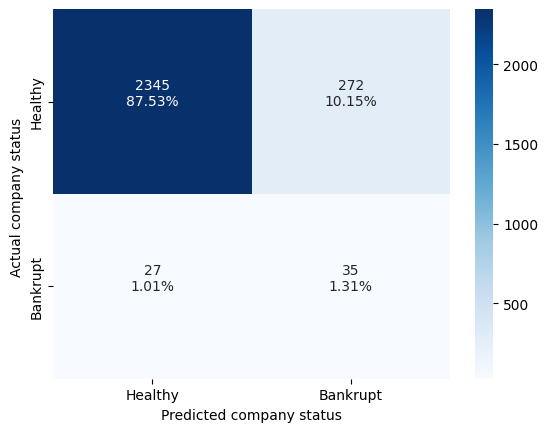


Finished with saving the confusion matrices. 
Working with classifier  NB
Finished with training in 0.0021 seconds
Train set
Acc: 0.77, Pre: 0.56, Rec: 0.41, F1: 0.48, AUC: 0.79
Test set
Acc: 0.87, Pre: 0.09, Rec: 0.50, F1: 0.15, AUC: 0.84


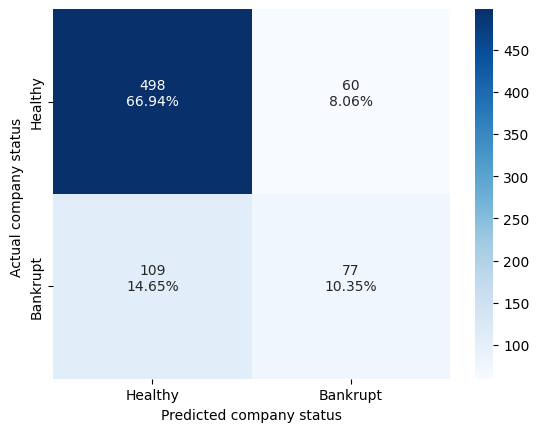

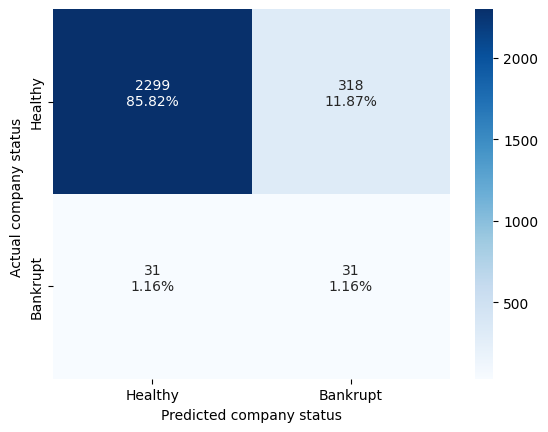


Finished with saving the confusion matrices. 
Working with classifier  SVM
Finished with training in 0.0163 seconds
Train set
Acc: 0.80, Pre: 0.76, Rec: 0.30, F1: 0.43, AUC: 0.84
Test set
Acc: 0.94, Pre: 0.17, Rec: 0.42, F1: 0.25, AUC: 0.85


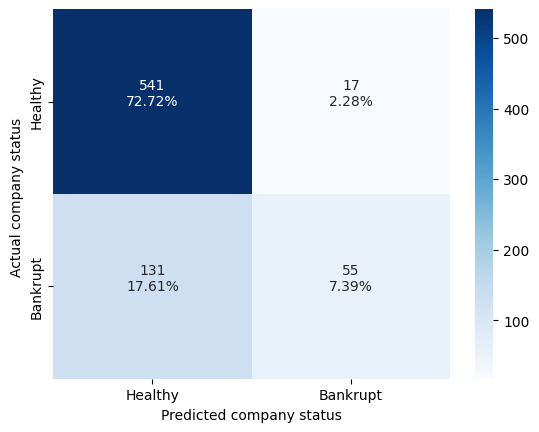

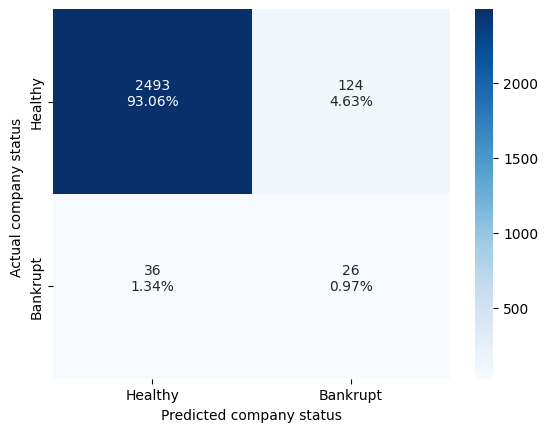


Finished with saving the confusion matrices. 
Working with classifier  GB
Finished with training in 0.2994 seconds
Train set
Acc: 0.94, Pre: 0.97, Rec: 0.77, F1: 0.86, AUC: 0.98
Test set
Acc: 0.92, Pre: 0.15, Rec: 0.56, F1: 0.24, AUC: 0.86


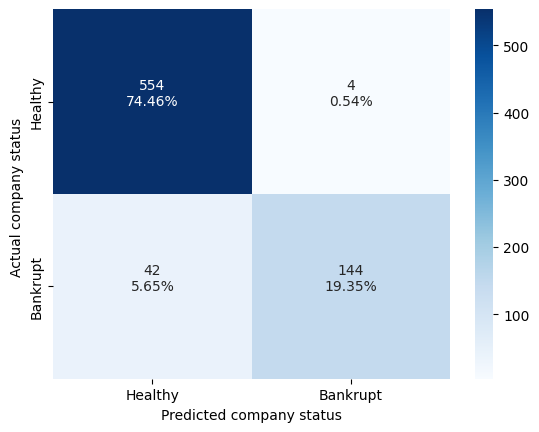

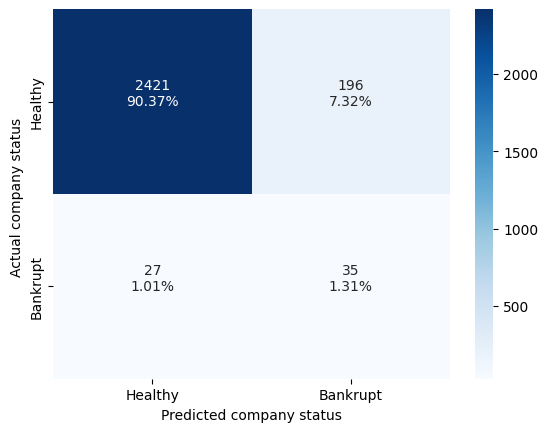


Finished with saving the confusion matrices. 
We are currently in Fold set: 3
-----------------
Initial Training Set
-----------------
Healthy companies : 7851
Bankrupt companies : 186
Total companies in training set: 8037
-----------------------------------

Resampling Training Set to fit 3:1 ratio
-----------------
Resampled Training Set
-----------------
Healthy companies : 558
Bankrupt companies : 186
Total companies in resampled training set: 744
-----------------------------------
-----------------
Test Set
-----------------
Healthy companies : 2617
Bankrupt companies : 62
Total companies in test set: 2679

Working with classifier  LDA
Finished with training in 0.0023 seconds
Train set
Acc: 0.80, Pre: 0.66, Rec: 0.39, F1: 0.49, AUC: 0.84
Test set
Acc: 0.91, Pre: 0.10, Rec: 0.34, F1: 0.16, AUC: 0.76


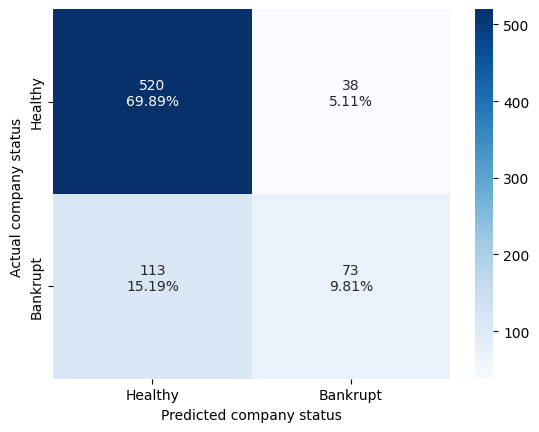

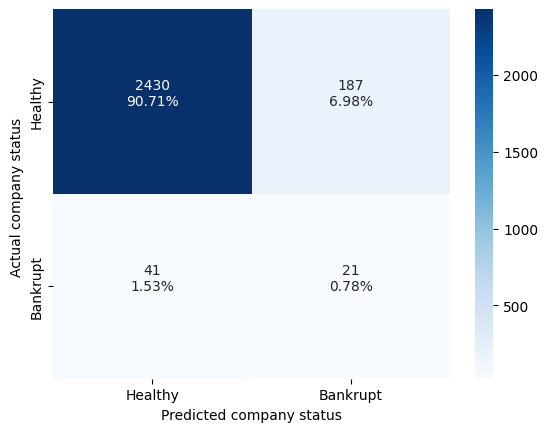


Finished with saving the confusion matrices. 
Working with classifier  LR
Finished with training in 0.0447 seconds
Train set
Acc: 0.80, Pre: 0.70, Rec: 0.34, F1: 0.46, AUC: 0.84
Test set
Acc: 0.92, Pre: 0.09, Rec: 0.26, F1: 0.14, AUC: 0.76


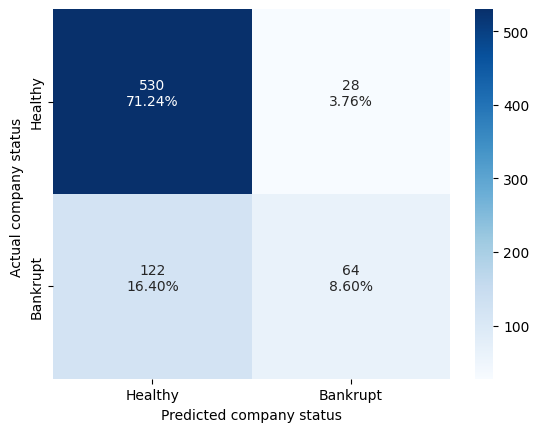

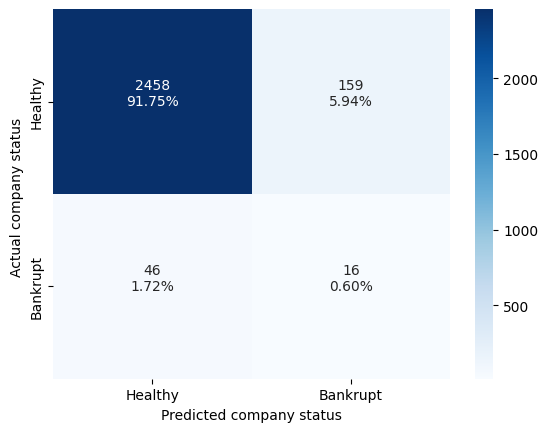


Finished with saving the confusion matrices. 
Working with classifier  Ctree
Finished with training in 0.0070 seconds
Train set
Acc: 1.00, Pre: 1.00, Rec: 1.00, F1: 1.00, AUC: 1.00
Test set
Acc: 0.83, Pre: 0.05, Rec: 0.37, F1: 0.09, AUC: 0.61


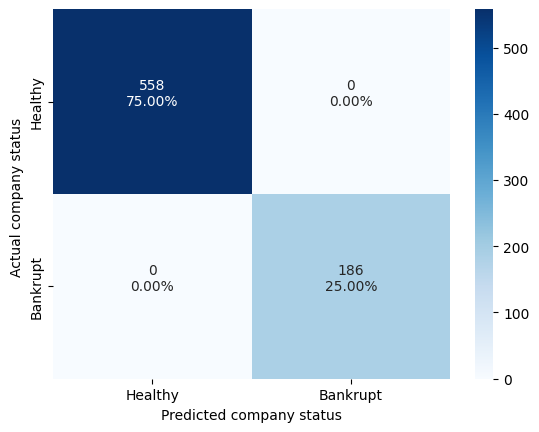

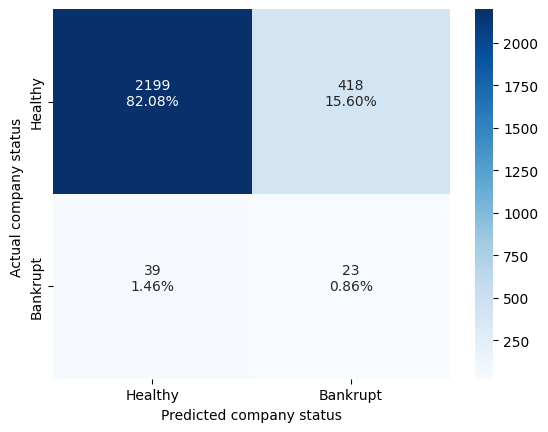


Finished with saving the confusion matrices. 
Working with classifier  RF
Finished with training in 0.2207 seconds
Train set
Acc: 1.00, Pre: 1.00, Rec: 1.00, F1: 1.00, AUC: 1.00
Test set
Acc: 0.91, Pre: 0.10, Rec: 0.35, F1: 0.16, AUC: 0.74


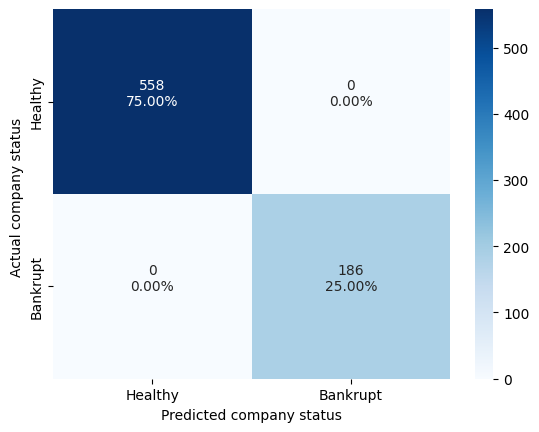

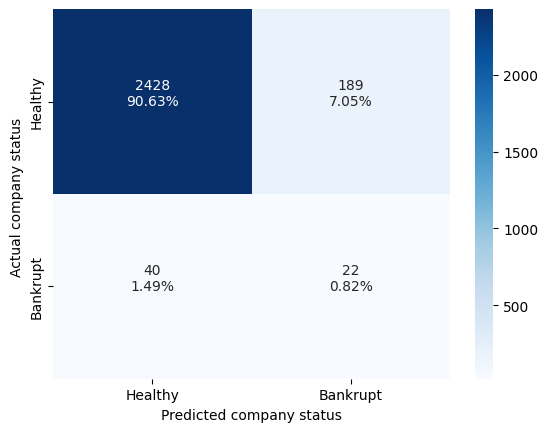


Finished with saving the confusion matrices. 
Working with classifier  kNN
Finished with training in 0.0024 seconds
Train set
Acc: 0.85, Pre: 0.74, Rec: 0.60, F1: 0.66, AUC: 0.91
Test set
Acc: 0.89, Pre: 0.08, Rec: 0.34, F1: 0.12, AUC: 0.71


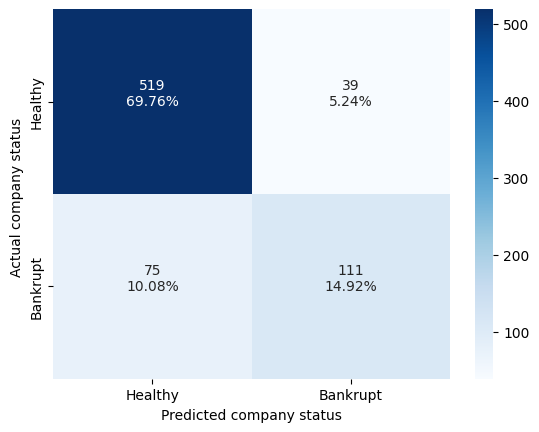

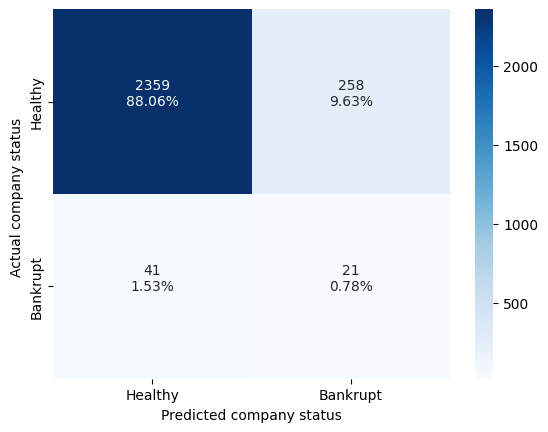


Finished with saving the confusion matrices. 
Working with classifier  NB
Finished with training in 0.0020 seconds
Train set
Acc: 0.76, Pre: 0.54, Rec: 0.41, F1: 0.47, AUC: 0.81
Test set
Acc: 0.86, Pre: 0.07, Rec: 0.39, F1: 0.12, AUC: 0.73


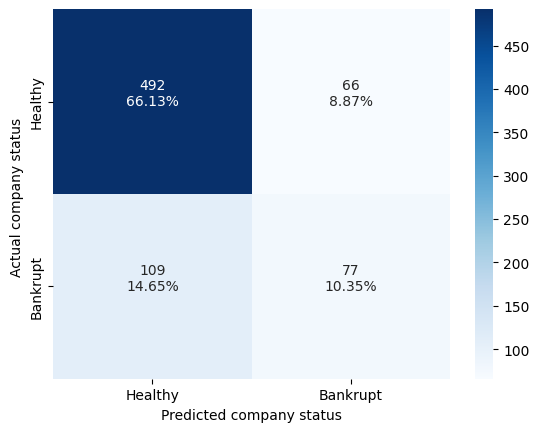

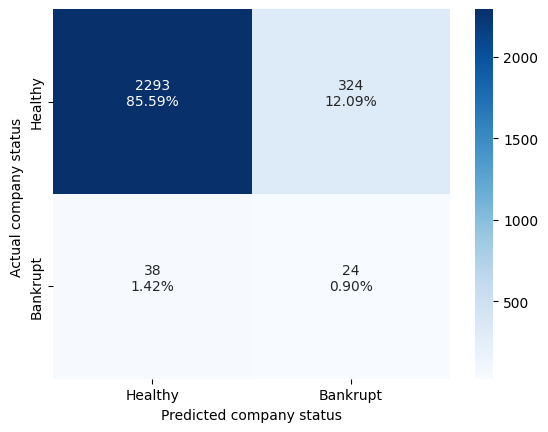


Finished with saving the confusion matrices. 
Working with classifier  SVM
Finished with training in 0.0156 seconds
Train set
Acc: 0.83, Pre: 0.76, Rec: 0.44, F1: 0.56, AUC: 0.87
Test set
Acc: 0.92, Pre: 0.11, Rec: 0.32, F1: 0.16, AUC: 0.72


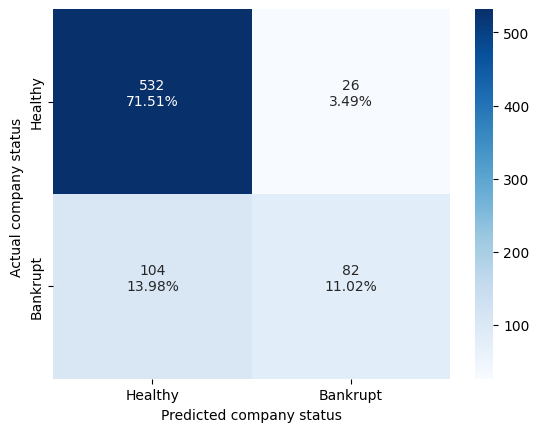

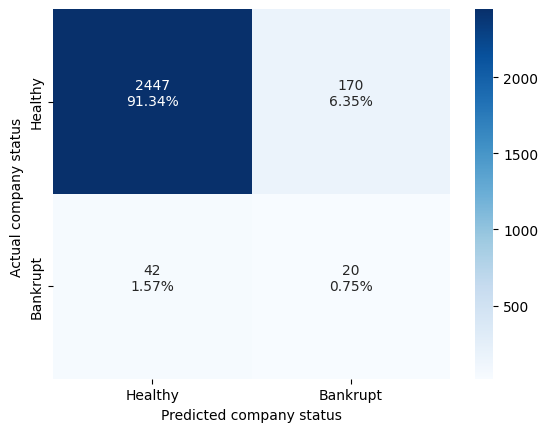


Finished with saving the confusion matrices. 
Working with classifier  GB
Finished with training in 0.3021 seconds
Train set
Acc: 0.95, Pre: 0.97, Rec: 0.82, F1: 0.89, AUC: 0.99
Test set
Acc: 0.90, Pre: 0.09, Rec: 0.34, F1: 0.14, AUC: 0.73


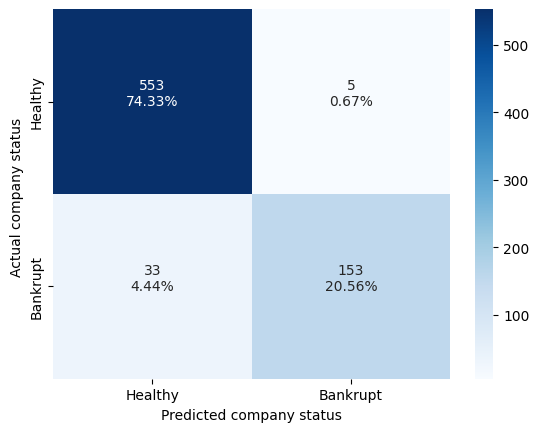

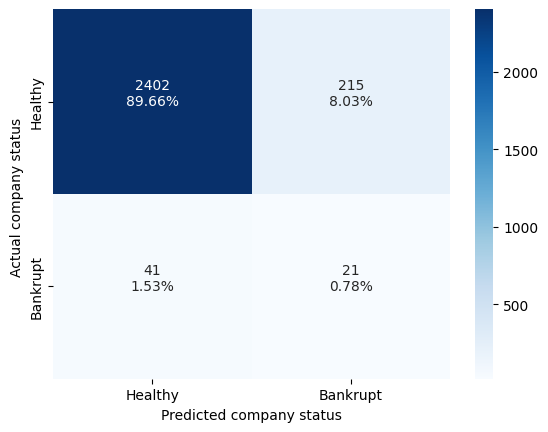


Finished with saving the confusion matrices. 
We are currently in Fold set: 4
-----------------
Initial Training Set
-----------------
Healthy companies : 7851
Bankrupt companies : 186
Total companies in training set: 8037
-----------------------------------

Resampling Training Set to fit 3:1 ratio
-----------------
Resampled Training Set
-----------------
Healthy companies : 558
Bankrupt companies : 186
Total companies in resampled training set: 744
-----------------------------------
-----------------
Test Set
-----------------
Healthy companies : 2617
Bankrupt companies : 62
Total companies in test set: 2679

Working with classifier  LDA
Finished with training in 0.0029 seconds
Train set
Acc: 0.82, Pre: 0.73, Rec: 0.42, F1: 0.53, AUC: 0.83
Test set
Acc: 0.92, Pre: 0.11, Rec: 0.35, F1: 0.17, AUC: 0.83


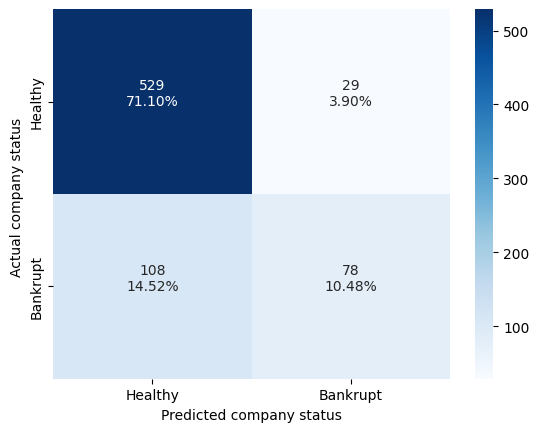

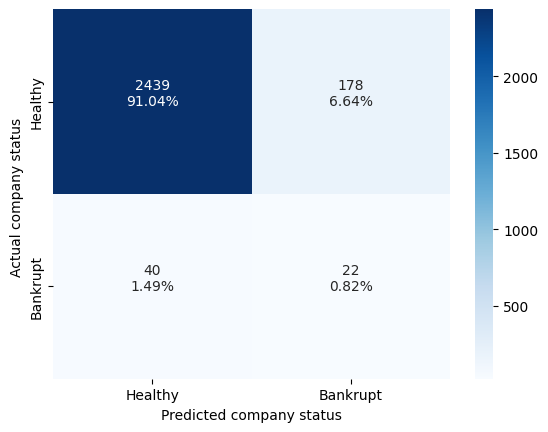


Finished with saving the confusion matrices. 
Working with classifier  LR
Finished with training in 0.1026 seconds
Train set
Acc: 0.80, Pre: 0.73, Rec: 0.34, F1: 0.46, AUC: 0.83
Test set
Acc: 0.93, Pre: 0.11, Rec: 0.29, F1: 0.16, AUC: 0.83


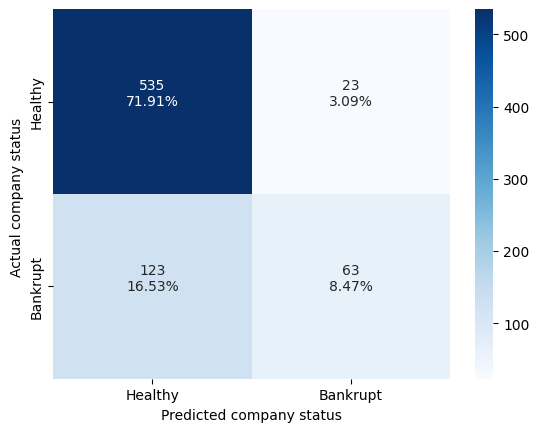

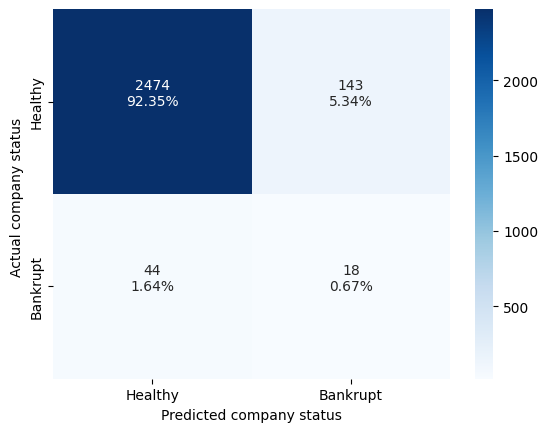


Finished with saving the confusion matrices. 
Working with classifier  Ctree
Finished with training in 0.0082 seconds
Train set
Acc: 1.00, Pre: 1.00, Rec: 1.00, F1: 1.00, AUC: 1.00
Test set
Acc: 0.80, Pre: 0.06, Rec: 0.48, F1: 0.10, AUC: 0.65


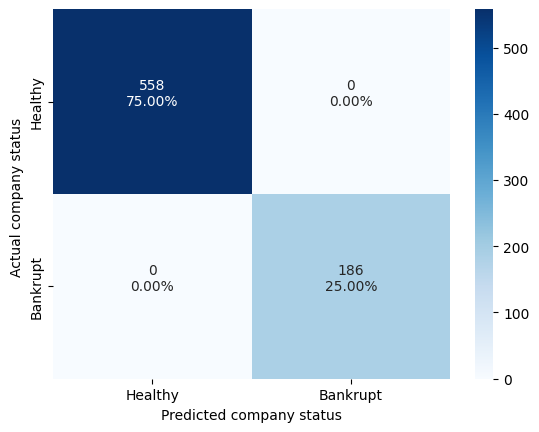

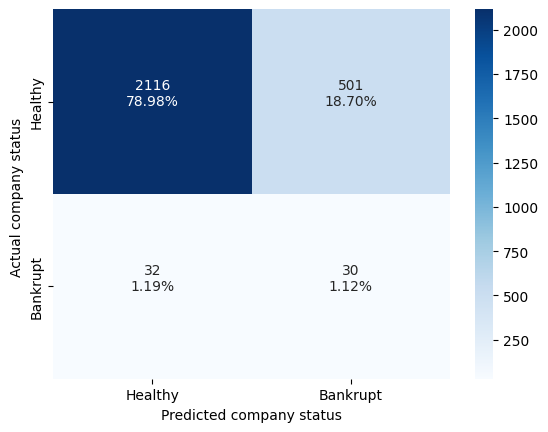


Finished with saving the confusion matrices. 
Working with classifier  RF
Finished with training in 0.2159 seconds
Train set
Acc: 1.00, Pre: 1.00, Rec: 1.00, F1: 1.00, AUC: 1.00
Test set
Acc: 0.92, Pre: 0.14, Rec: 0.52, F1: 0.22, AUC: 0.84


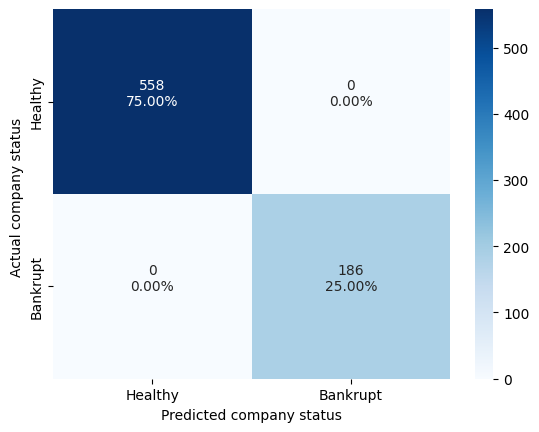

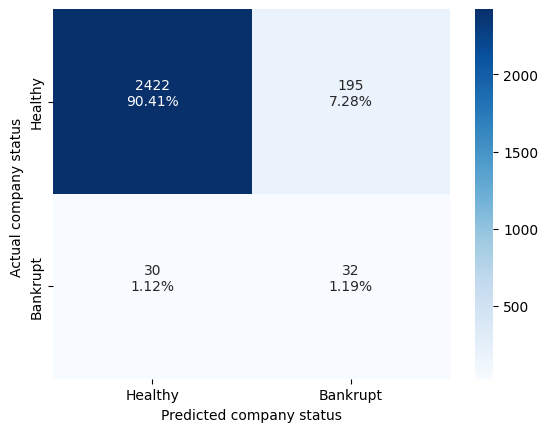


Finished with saving the confusion matrices. 
Working with classifier  kNN
Finished with training in 0.0027 seconds
Train set
Acc: 0.84, Pre: 0.72, Rec: 0.59, F1: 0.65, AUC: 0.91
Test set
Acc: 0.89, Pre: 0.10, Rec: 0.48, F1: 0.16, AUC: 0.77


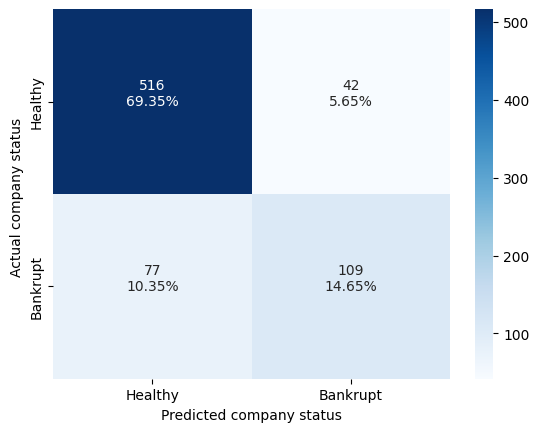

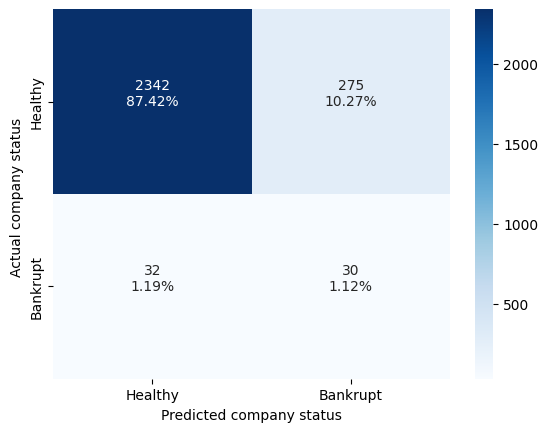


Finished with saving the confusion matrices. 
Working with classifier  NB
Finished with training in 0.0023 seconds
Train set
Acc: 0.77, Pre: 0.56, Rec: 0.42, F1: 0.48, AUC: 0.79
Test set
Acc: 0.88, Pre: 0.07, Rec: 0.37, F1: 0.12, AUC: 0.82


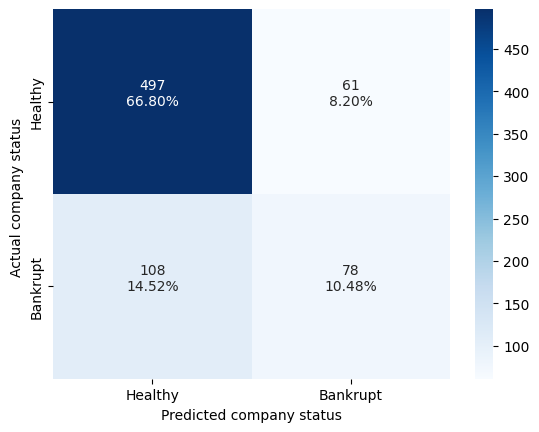

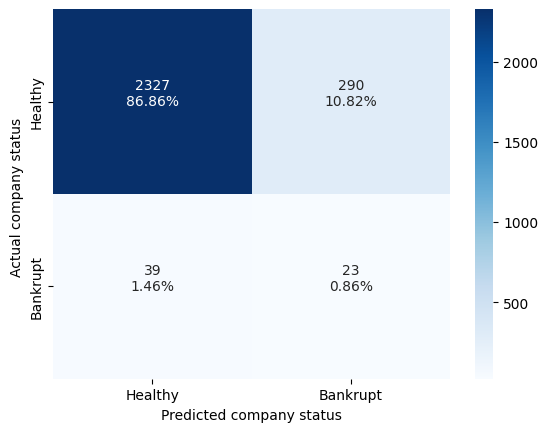


Finished with saving the confusion matrices. 
Working with classifier  SVM
Finished with training in 0.0290 seconds
Train set
Acc: 0.84, Pre: 0.83, Rec: 0.44, F1: 0.58, AUC: 0.85
Test set
Acc: 0.93, Pre: 0.14, Rec: 0.39, F1: 0.20, AUC: 0.84


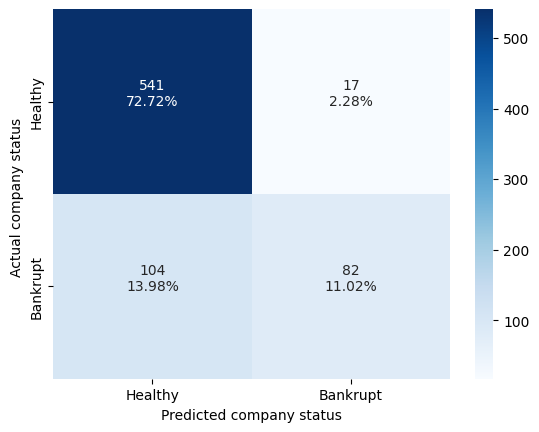

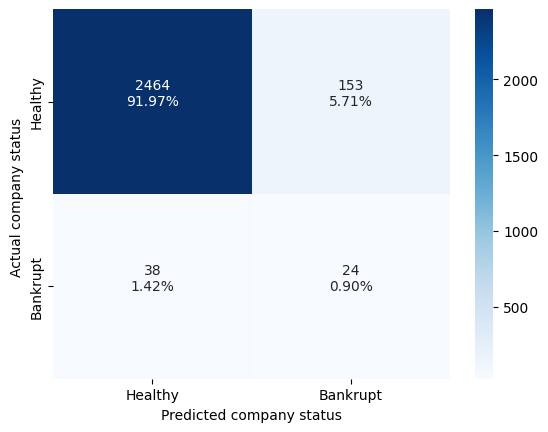


Finished with saving the confusion matrices. 
Working with classifier  GB
Finished with training in 0.3717 seconds
Train set
Acc: 0.95, Pre: 0.97, Rec: 0.84, F1: 0.90, AUC: 0.99
Test set
Acc: 0.90, Pre: 0.13, Rec: 0.55, F1: 0.20, AUC: 0.85


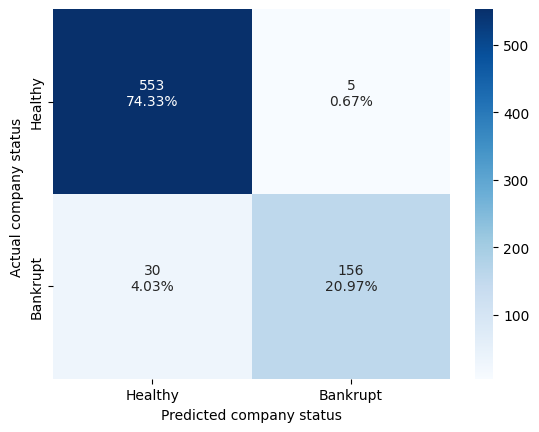

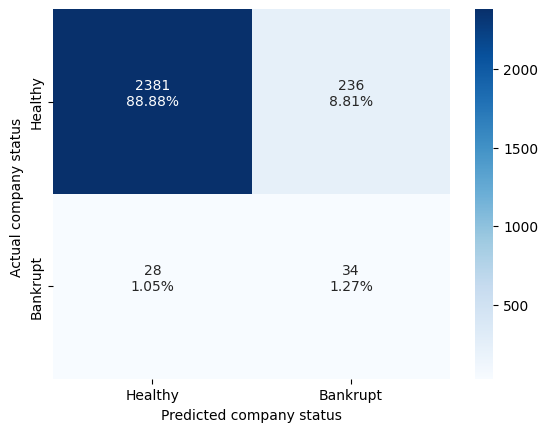


Finished with saving the confusion matrices. 


In [ ]:
#6# For each fold print the number of healthy and bankrupt companies
#7# ratio in training set should be 3 healthy to 1 bankrupt for each fold. if not, balance it
#8# train with models : LDA, LR, Ctree, RF, kNN, NB, SCV, GB

foldSetNum = 1;
#For each set of folds :
# (1) prints H and B companies
# (2) balances the dataset if ratio is greater than 3 H to 1 B
# (3) prints H and B companies again
# (4) trains models LDA, LR, Ctree, RF, kNN, NB, SCV, GB
# (5) prints confusion matrices for each model
# (6) extracts data to csv
for train_index, test_index in stratified_kfold.split(inputData, outputData):
  print("==============================================")
  print(f"We are currently in Fold set: {foldSetNum}")
  print("==============================================")

  #first balance the fold. then run each model and for each model run create a line in the csv file
  #split training and test sets
  x_train = inputData[train_index]
  x_test = inputData[test_index]
  y_train = outputData[train_index]
  y_test = outputData[test_index]

  #count classes in training set
  healthyCompanies = np.sum(y_train == 1)
  bankruptCompanies = np.sum(y_train == 2)
  newTrainIndex = train_index

  print("-----------------")
  print("Initial Training Set")
  print("-----------------")
  #print(f"Train Set Index: {train_index}")
  print(f"Healthy companies : {healthyCompanies}")
  print(f"Bankrupt companies : {bankruptCompanies}")
  print(f"Total companies in training set: {healthyCompanies + bankruptCompanies}")
  print("-----------------------------------")

  #if ratio is greater than 3:1 balance the fold with the function
  if healthyCompanies > 3 * bankruptCompanies:
    print()
    print("Resampling Training Set to fit 3:1 ratio")
    x_train, y_train, selectedIndexes = balanceFold(x_train, y_train)
    newTrainIndex = train_index[selectedIndexes]
    #print(len(x_train))
    #print(len(newTrainIndex))

  #count again after resampling
  healthyCompanies = np.sum(y_train == 1)
  bankruptCompanies = np.sum(y_train == 2)

  print("-----------------")
  print("Resampled Training Set")
  print("-----------------")
  #print(f"Train Set Index: {newTrainIndex}")
  print(f"Healthy companies : {healthyCompanies}")
  print(f"Bankrupt companies : {bankruptCompanies}")
  print(f"Total companies in resampled training set: {healthyCompanies + bankruptCompanies}")
  print("-----------------------------------")

  # Count classes in test set
  healthyCompanies = np.sum(y_test == 1)
  bankruptCompanies = np.sum(y_test == 2)

  print("-----------------")
  print("Test Set")
  print("-----------------")
  #print(f"Test Set Index: {test_index}")
  print(f"Healthy companies : {healthyCompanies}")
  print(f"Bankrupt companies : {bankruptCompanies}")
  print(f"Total companies in test set: {healthyCompanies + bankruptCompanies}")
  print()
  #print(pd.Series(outputData[newTrainIndex]).describe())

  #begin training the models
  #Linear Discriminant Analysis
  one_model_sim_function("LDA", LinearDiscriminantAnalysis(), inputData, outputData,\
                           newTrainIndex, test_index,\
                          figuresFolderPath, "balanced",foldSetNum)
  #Logistic Regression
  one_model_sim_function("LR", LogisticRegression(), inputData, outputData,\
                           newTrainIndex, test_index,\
                          figuresFolderPath, "balanced",foldSetNum)
  #Decision Trees
  one_model_sim_function("Ctree", DecisionTreeClassifier(), inputData, outputData,\
                           newTrainIndex, test_index,\
                          figuresFolderPath, "balanced",foldSetNum)
  #Random Forests
  one_model_sim_function("RF", RandomForestClassifier(), inputData, outputData,\
                           newTrainIndex, test_index,\
                          figuresFolderPath, "balanced",foldSetNum)
  #k-Nearest Neighbours
  one_model_sim_function("kNN", KNeighborsClassifier(), inputData, outputData,\
                          newTrainIndex, test_index,\
                        figuresFolderPath, "balanced",foldSetNum)
  #Naive Bayes
  one_model_sim_function("NB", GaussianNB(), inputData, outputData,\
                          newTrainIndex, test_index,\
                        figuresFolderPath, "balanced",foldSetNum)

  #Support Vector Machines
  one_model_sim_function("SVM", SVC(), inputData, outputData,\
                          newTrainIndex, test_index,\
                        figuresFolderPath, "balanced",foldSetNum)

  #Gradient Boosting
  one_model_sim_function("GB", GradientBoostingClassifier(), inputData, outputData,\
                          newTrainIndex, test_index,\
                        figuresFolderPath, "balanced",foldSetNum)

  foldSetNum += 1

In [ ]:
#10# export results to drive in csv
resultsDataframe.to_csv('/content/drive/My Drive/mai25067-assignment2/results.csv', index=False)